### Extended Isolation Forest (EIF) Trial

Experimenting with H2O EIF

In [3]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd())))

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, kendalltau

from typing import Callable, Any
from sklearn.datasets import make_moons, make_circles
from sklearn.ensemble import IsolationForest as SklearnIsolationForest

from src.isolation.tree import IsolationTree
from src.isolation.forest import IsolationForest
from src.kmeans_isolation.tree import KMeansIsolationTree
from src.kmeans_isolation.forest import KMeansIsolationForest

import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator


# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("All imports successful \u2705")

All imports successful ✅


In [4]:
def time_execution(
    func: Callable, 
    n_runs: int = 5, 
    *args, **kwargs
) -> tuple[float, float]:
    """Time function execution over multiple runs.
    Args:
        func: Function to time
        n_runs: Number of runs for averaging
        *args, **kwargs: Arguments to pass to func
    Returns:
        (mean_time, std_time) in seconds
    """
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        times.append(end - start)
    return np.float64(np.mean(times)), np.float64(np.std(times))


def generate_rectangles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate 9 rectangles in a 3x3 grid dataset with anomalies."""
    np.random.seed(seed)
    rectangles = []
    for i in range(3):
        for j in range(3):
            Xs_rectangle = np.random.uniform(
                low=[i * 3.0, j * 3.0],
                high=[i * 3.0 + 2.0, j * 3.0 + 2.0],
                size=(n_normal // 9, 2)
            )
            rectangles.append(Xs_rectangle)
    Xs_normal = np.vstack(rectangles)
    
    # Anomalies scattered randomly
    Xs_anomalies = np.random.uniform(
        low=[0.0, 0.0],
        high=[9.0, 9.0],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_moons_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate moons dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_moons(n_samples=n_normal, noise=0.05, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_circles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100,
    seed: int = 42
):
    """Generate circles dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_circles(n_samples=n_normal, noise=0.0, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_synthetic_dataset(
    n_samples: int, 
    n_features: int, 
    contamination: float = 0.1, 
    seed: int = 42
):
    """Generate synthetic high-dimensional dataset."""
    np.random.seed(seed)
    
    n_normal = int(n_samples * (1 - contamination))
    n_anomalies = n_samples - n_normal
    
    # Normal samples from standard normal
    X_normal = np.random.randn(n_normal, n_features)
    
    # Anomalies from shifted/scaled distribution
    X_anomalies = np.random.randn(n_anomalies, n_features) * 3 + 5
    
    X = np.vstack([X_normal, X_anomalies])
    y = np.array([0] * n_normal + [1] * n_anomalies)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    return X[indices].astype(np.float64), y[indices]


print("Utility functions defined \u2705")

Utility functions defined ✅


In [5]:
import pyod
from pyod.models.iforest import IForest as PyODIForest
from pyod.models.knn import KNN as PyODKNN  # K-NN based detector as alternative

In [12]:
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD

print("-"*80)
print("PyOD Additional Algorithms Comparison")
print("-"*80)

n_samples_test = 50000
X_test = generate_moons_dataset(n_normal=n_samples_test - 5000, n_anomalies=5000, seed=42)[0]

print(f"\nTesting on {n_samples_test} samples with various PyOD algorithms:\n")

algorithms = [
    ('PyOD IForest', PyODIForest(n_estimators=100, max_samples=256, random_state=42, n_jobs=-1)),
    ('PyOD LOF', LOF(n_neighbors=20, n_jobs=-1)),
    ('PyOD COPOD', COPOD()),
    ('PyOD ECOD', ECOD()),
    ('PyOD KNN', PyODKNN(n_neighbors=20, n_jobs=-1)),
    ('H2o Extended IForest', None),  # Will handle separately
    ('Our IForest', None),    # Will handle separately
    ('Our KMeans IF', None),  # Will handle separately
]

results_pyod_algos = []

for name, clf in algorithms:
    if name == 'Our IForest':
        def train_fn():
            forest = IsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    elif name == 'Our KMeans IF':
        def train_fn():
            forest = KMeansIsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    elif name == 'H2o Extended IForest':
        h2o.init(verbose=False)

        h2o.remove_all()
        h2o_X_test = h2o.H2OFrame(X_test)
        
        def train_fn():
            h2o_clf = H2OExtendedIsolationForestEstimator(
                ntrees=100,
                sample_size=256,
                seed=42
            )
            h2o_clf.train(training_frame=h2o_X_test)
    else:
        def train_fn():
            clf.fit(X_test)
    
    mean_time, std_time = time_execution(train_fn, n_runs=5)
    print(f"  {name:20s}: {mean_time:.4f}s \u00B1 {std_time:.4f}s")
    
    results_pyod_algos.append({
        'Algorithm': name,
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })

df_pyod_algos = pd.DataFrame(results_pyod_algos)

print("\n" + "-"*80)
print("SUMMARY: PyOD Algorithms on 50K samples")
print("-"*80)
print(df_pyod_algos.sort_values('Mean Time (s)').to_string(index=False))

# Save results
df_pyod_algos.to_csv('../results/timing/h2o_algorithms_comparison.csv', index=False)

print("\nResults saved to results/timing/h2o_algorithms_comparison.csv \u2705")

--------------------------------------------------------------------------------
PyOD Additional Algorithms Comparison
--------------------------------------------------------------------------------

Testing on 50000 samples with various PyOD algorithms:

  PyOD IForest        : 0.4045s ± 0.0091s
  PyOD LOF            : 0.1296s ± 0.0059s
  PyOD COPOD          : 0.0298s ± 0.0068s
  PyOD ECOD           : 0.0309s ± 0.0075s
  PyOD KNN            : 0.1484s ± 0.0156s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |███████████

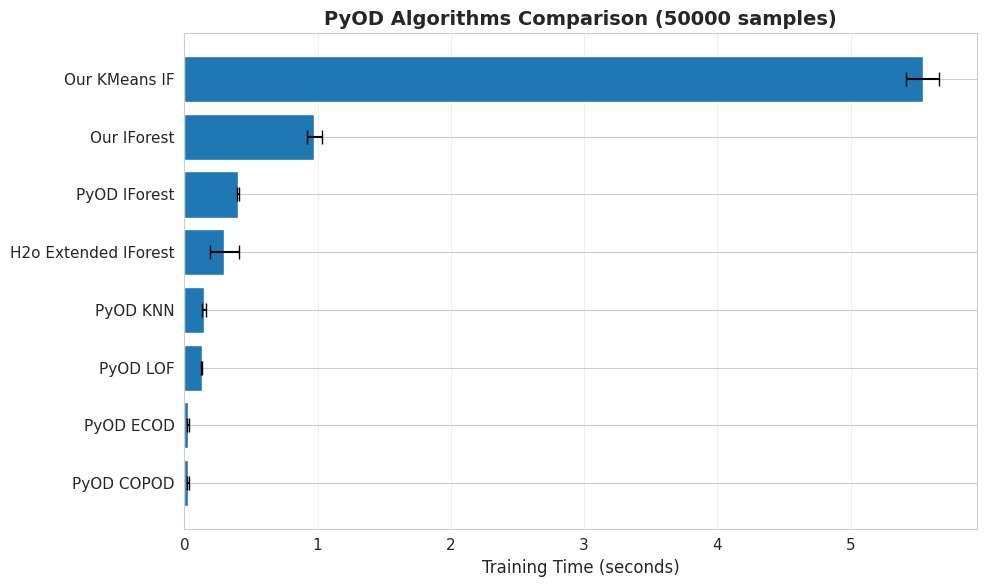


Plot saved to: results/timing/h2o_algorithms_comparison.png ✅


In [13]:
plt.figure(figsize=(10, 6))

df_sorted = df_pyod_algos.sort_values('Mean Time (s)')

plt.barh(df_sorted['Algorithm'], df_sorted['Mean Time (s)'], xerr=df_sorted['Std Time (s)'], capsize=5)

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.title(f'PyOD Algorithms Comparison ({n_samples_test} samples)', fontsize=14, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('../results/timing/h2o_algorithms_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/timing/h2o_algorithms_comparison.png \u2705")